In [6]:
# /*==========================================================================================*\
# **                        _           _ _   _     _  _         _                            **
# **                       | |__  _   _/ | |_| |__ | || |  _ __ | |__                         **
# **                       | '_ \| | | | | __| '_ \| || |_| '_ \| '_ \                        **
# **                       | |_) | |_| | | |_| | | |__   _| | | | | | |                       **
# **                       |_.__/ \__,_|_|\__|_| |_|  |_| |_| |_|_| |_|                       **
# \*==========================================================================================*/


# -----------------------------------------------------------------------------------------------
# Author: Bùi Tiến Thành (@bu1th4nh)
# Title: data_analysis.ipynb
# Date: 2024/10/07 21:58:11
# Description: 
# 
# (c) bu1th4nh. All rights reserved
# -----------------------------------------------------------------------------------------------

import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


ORGL_PATH = '/home/ti514716/Datasets/BreastCancer/processed_crossOmics'
RESULT_PATH = '/home/ti514716/Projects/SimilarSampleCrossOmicNMF/results'
METHODS = ["AdaBoost", "Logistic Regression", "Random Forest", "SVM"]
DISABLE_MLFLOW = True
TRAIN_TIME = 100


run_presets = [
    # Not fixed gamma
    # Alpha = 2
    {
        'run_name'  : 'ariel-elsa-aurora-20241002-15.12.43',
        'run_id'    : 'd4cf242b1a3540d5b2cb91dc52dbd991',
    },
    # Alpha = 1
    {
        'run_name'  : 'ariel-moana-mulan-20241002-23.32.36',
        'run_id'    : '1e2f0bbe6ada401aae9d027bcd0fa8b5',
    },
    # Fixed gamma
    {
        'run_name'  : 'merida-mulan-anna-20241003-08.56.41',
        'run_id'    : 'abc7d2cfd6d04ab7b48de90d24e8cfc4',
    },
    # Baseline: NMF Only
    {
        'run_name'  : 'rapunzel-rapunzel-ariel-20241006-10.23.03',
        'run_id'    : '7f933693ee25409c8fdb90b04a5a26b8',
    },
    # Baseline: Raw
    # {
    #     'run_name'  : 'baseline_rawdata',
    #     'run_id'    : '62565423ab374538bddded038085c625',
    # },
]

attempts = json.loads(open('attempts__500pass_samerandstate.json').read())

In [7]:
def evaluate(run_preset, attempts):
    # -----------------------------------------------------------------------------------------------
    # Build results
    # -----------------------------------------------------------------------------------------------
    run_id = run_preset['run_id']
    run_name = run_preset['run_name']
    preset_results_auc = {
        "AdaBoost"              : [],
        "Logistic Regression"   : [],
        "Random Forest"         : [],
        "SVM"                   : [],
    }

    # Attempts: List[Dict[Preset, Dict[Method, Dict[Metrics, Value]]]]
    for attempt in attempts:
        preset = attempt[run_id]
        for method in METHODS:
            preset_results_auc[method].append(preset[method]['auc'])
            

    # -----------------------------------------------------------------------------------------------
    # Plot & arrays intialization
    # -----------------------------------------------------------------------------------------------
    # AUC Histogram
    auc_hist_fig, auc_hist_ax = plt.subplots(2, 2, figsize=(20, 7))
    auc_hist_fig.suptitle(f"AUC Hist - {len(attempts)} pass")

    # AUC Boxplot
    combined_auc_data = []
    combined_auc_labels = []
    auc_box_fig, auc_box_ax = plt.subplots(figsize=(20, 7))
    auc_box_ax.set_title(f"Boxplot AUC - {len(attempts)} pass")

    # Nearest ROC Curve
    auc_nr_fig, auc_nr_ax = plt.subplots(2, 2, figsize=(20, 7))
    auc_nr_fig.suptitle(f"Nearest ROC Curve - {len(attempts)} pass")


    # -----------------------------------------------------------------------------------------------
    # Evaluate
    # -----------------------------------------------------------------------------------------------
    for meth_id, cls_method in enumerate(METHODS):
        # Descriptive statistics
        aucs = preset_results_auc[cls_method]
        avg_auc = np.mean(aucs)
        std_auc = np.std(aucs)
        max_auc = np.max(aucs)
        min_auc = np.min(aucs)
        nearest_auc = np.argmin(np.abs(aucs - avg_auc))


        # Logging
        # logging.info(f"Method: {cls_method}")
        # logging.info(f"Mean AUC: {avg_auc}")
        # logging.info(f"Std AUC: {std_auc}")
        # logging.info(f"Max AUC: {max_auc}")
        # logging.info(f"Min AUC: {min_auc}")
        # if not DISABLE_MLFLOW: mlflow.log_metric(f"{cls_method} Mean AUC {TRAIN_TIME} pass", mean_auc)



        # Histogram
        axxx = auc_hist_ax[meth_id//2, meth_id%2]
        sns.histplot(preset_results_auc[method], kde=True, ax=axxx)
        axxx.set_title(f'{method} AUC = {avg_auc:.4f} ± {std_auc:.4f} [{min_auc:.4f}, {max_auc:.4f}]')


        # Nearest ROC Curve
        axxx = auc_nr_ax[meth_id//2, meth_id%2]
        tpr = attempts[nearest_auc][run_id][method]['tpr']
        fpr = attempts[nearest_auc][run_id][method]['fpr']
        axxx.plot(fpr, tpr)
        axxx.set_title(f'{method} AUC = {avg_auc:.4f} @ attempt #[{nearest_auc}]')


        # Boxplot
        combined_auc_data += aucs
        combined_auc_labels += [cls_method] * len(aucs)
    sns.boxplot(x=combined_auc_labels, y=combined_auc_data, ax=auc_box_ax)

    # -----------------------------------------------------------------------------------------------
    # Show
    # -----------------------------------------------------------------------------------------------
    auc_hist_fig.show()
    auc_box_fig.show()
    auc_nr_fig.show()

    # -----------------------------------------------------------------------------------------------
    # Save results
    # -----------------------------------------------------------------------------------------------
    # auc_hist_fig.savefig(f"{RESULT_PATH}/{run_name}/auc_hist_{TRAIN_TIME}pass.pdf")
    # auc_box_fig.savefig(f"{RESULT_PATH}/{run_name}/auc_box_{TRAIN_TIME}pass.pdf")
    # auc_nr_fig.savefig(f"{RESULT_PATH}/{run_name}/auc_nr_{TRAIN_TIME}pass.pdf")

    # if not DISABLE_MLFLOW:
    #     mlflow.log_artifact(f"{RESULT_PATH}/{run_name}/auc_hist_{TRAIN_TIME}pass.pdf")
    #     mlflow.log_artifact(f"{RESULT_PATH}/{run_name}/auc_box_{TRAIN_TIME}pass.pdf")
    #     mlflow.log_artifact(f"{RESULT_PATH}/{run_name}/auc_nr_{TRAIN_TIME}pass.pdf")
        
 

Analyzing ariel-elsa-aurora-20241002-15.12.43


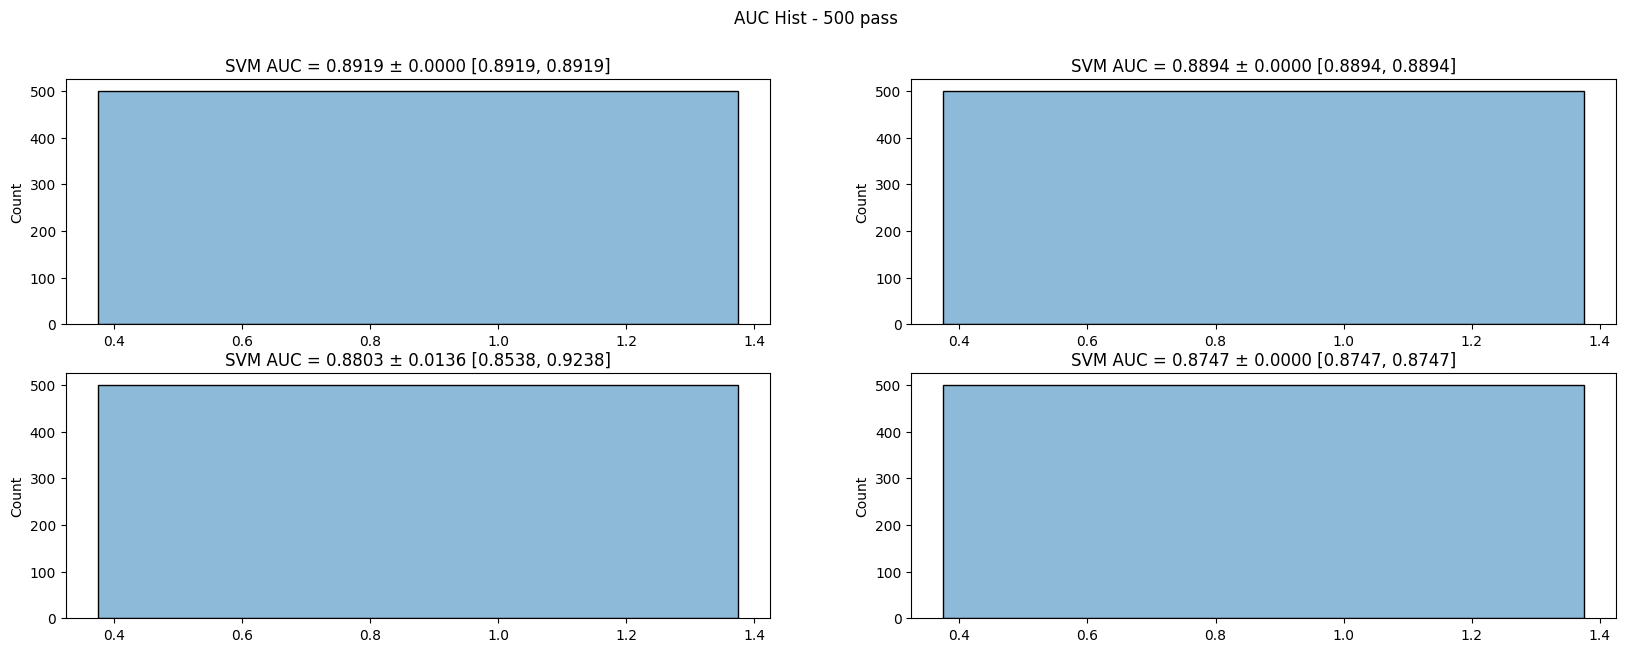

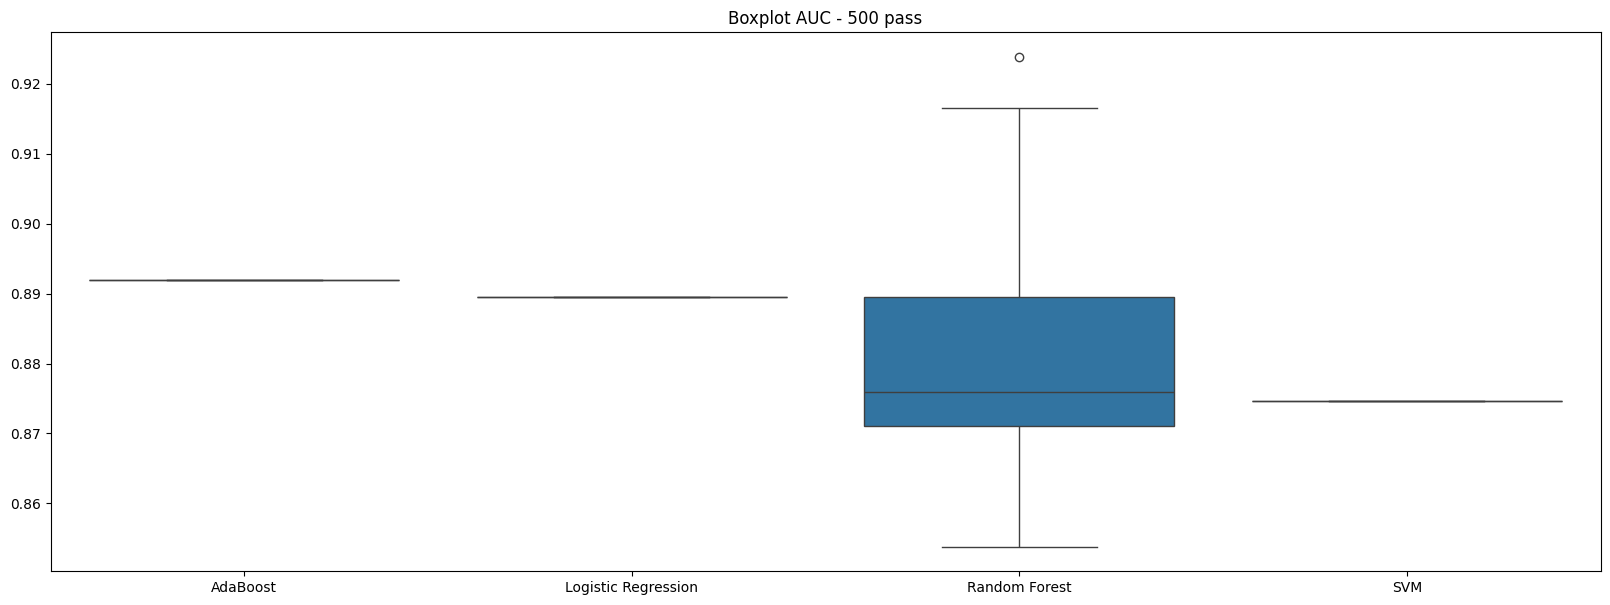

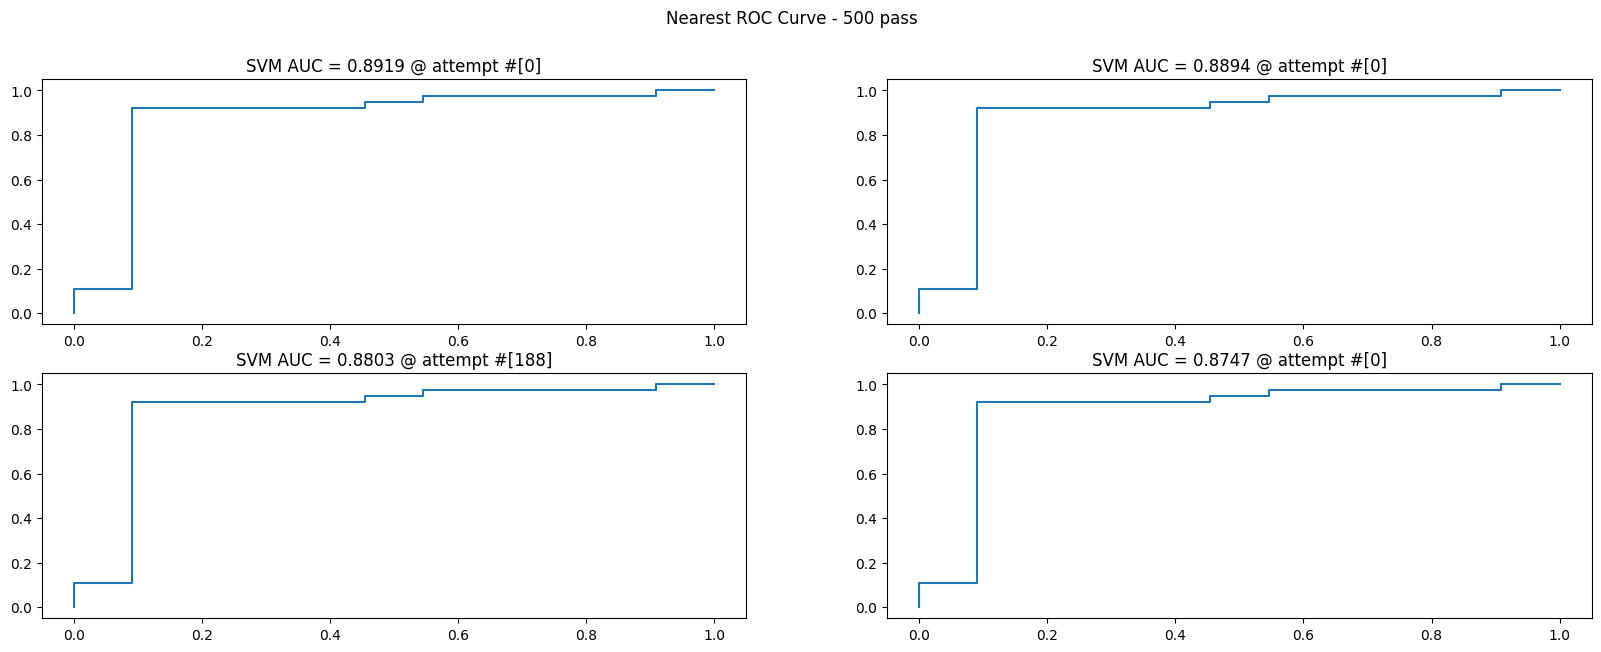

In [8]:
for run_preset in run_presets[:1]:   
    print(f'Analyzing {run_preset["run_name"]}')
    evaluate(run_preset, attempts)